# Tutorial Geospatial Data

## Part #4 GeoSeries and Spatial Relationships

in this chapter we'll explore the attributes and methods of a GeoPandas GeoSeries. 

Another aspect of geospatial data is how they relate to each other in space. Thus, you will learn the different spatial relationships, and how to use them in Python to query the data or to perform spatial joins.

### Preparation

In [1]:
# import pandas and matplotlib
import pandas as pd
import matplotlib.pyplot as plt

# import geospatial libraries
import geopandas as gpd
from shapely.geometry import Point

In [2]:
# loading the restaurants DataFrame
restaurants = pd.read_csv('Data/Cleansed_Data/Berlin_Restaurants')

# creating a GeoDataFrame
geometry = restaurants.apply(lambda x: Point((x.lng, x.lat)), axis=1)
crs = {'init':'epsg:4326'}
restaurants_geodf = gpd.GeoDataFrame(restaurants, crs=crs, geometry=geometry)
type(restaurants_geodf)

geopandas.geodataframe.GeoDataFrame

*(This dataset is sourced from [tour-pedia](http://tour-pedia.org/about/datasets.html).)*

### GeoSeries Attributes and Methods

Now we'll explore the attributes and methods of a GeoPandas GeoSeries, which you can think of as a geometry column of the GeoDataFrame:

In [3]:
berlin_districs = gpd.read_file('Data/Cleansed_Data/Berlin_Districts.shp')
berlin_districs.head(2)

,OBJECTID,DISTRICT,Shape__Are,Shape__Len,POPULATION,geometry
0,1,Reinickendorf,2.416586e+08,85589.289316,263920,"POLYGON ((13.3207443281765 52.6265990635925, 1..."
1,2,Charlottenburg-Wilmersdorf,1.742738e+08,71785.131858,338923,"POLYGON ((13.3211096415616 52.5244629906886, 1..."


In [4]:
type(berlin_districs.geometry)

geopandas.geoseries.GeoSeries

***The Area Attribute***

GeoPandas inherits a number of useful methods and attributes from the Shapely package. The `area` attribute for example returns the calculated area of a geometry:

In [5]:
berlin_districs.geometry.area

0     0.011846
1     0.008561
2     0.022161
3     0.013689
4     0.005938
5     0.006902
6     0.008184
7     0.012165
8     0.013552
9     0.005218
10    0.002700
11    0.007011
dtype: float64

Let's print the sorted areas:

In [6]:
# calculate area of each district
district_area = berlin_districs.geometry.area

# print the areas sorted ...
print(district_area.sort_values(ascending=False))

# ... and the crs in use
print()
print(berlin_districs.crs)

2     0.022161
3     0.013689
8     0.013552
7     0.012165
0     0.011846
1     0.008561
6     0.008184
11    0.007011
5     0.006902
4     0.005938
9     0.005218
10    0.002700
dtype: float64

{'init': 'epsg:4326'}


The third row (with index 2) is the largest district. Recall that the distance unit for a geometry is dependent on its *Coordinate Reference System (CRS)*. The CRS for the Berlin districts data is *epsg:4326* which uses decimal degrees for distance. So the area units here are decimal degrees squared.

Let's find the area in a way that's a little more comprehensible to us: kilometers squared. We can change the CRS to one that uses meters for distance: *epsg 3857* using `.to_crs()` and then convert meters^2 to kilometers^2:

In [7]:
# create a copy of berlin_districts that uses EPSG:3857
berlin_districts_3857 = berlin_districs.to_crs(epsg=3857)

# define a variable for m^2 to km^2
sqm_to_sqkm = 10**6

# get area in kilometers squared
district_area_km = berlin_districts_3857.geometry.area / sqm_to_sqkm
print(district_area_km.sort_values(ascending=False))
print()
print(berlin_districts_3857.crs)

2     450.397219
3     279.266143
8     275.457357
7     247.776994
0     241.658604
1     174.273771
6     166.680203
11    142.522777
5     140.619878
4     120.712189
9     106.288207
10     54.961010
dtype: float64

{'init': 'epsg:3857', 'no_defs': True}


***The Centroid Method***

The `centroid` method returns the point at the center of each geometry in a GeoSeries:

In [8]:
# centroid of first polygon
print(berlin_districs.geometry.centroid[0])

POINT (13.29133831905174 52.59568176222349)


... which could also be stored in a new column:

In [9]:
# create center column from the centroid
berlin_districs['center'] = berlin_districs.geometry.centroid

berlin_districs.head(2)

,OBJECTID,DISTRICT,Shape__Are,Shape__Len,POPULATION,geometry,center
0,1,Reinickendorf,2.416586e+08,85589.289316,263920,"POLYGON ((13.3207443281765 52.6265990635925, 1...",POINT (13.29133831905174 52.59568176222349)
1,2,Charlottenburg-Wilmersdorf,1.742738e+08,71785.131858,338923,"POLYGON ((13.3211096415616 52.5244629906886, 1...",POINT (13.27023027540493 52.50104015156788)


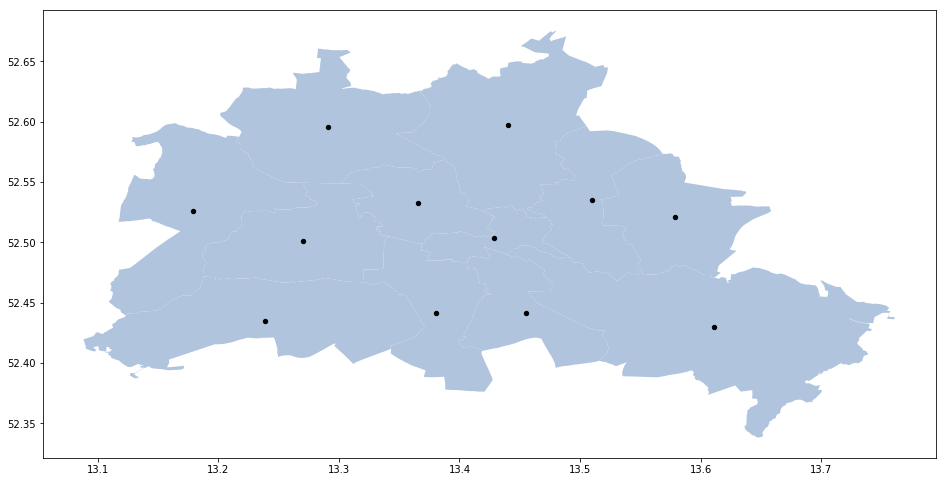

In [10]:
# store the centroids in a GeoSeries
berlin_centroids = berlin_districs.geometry.centroid

# plot districts as ax and add the centroids
ax = berlin_districs.plot(color='lightsteelblue', figsize=(16,16))
berlin_centroids.plot(ax=ax, color='black', markersize=19)

# show the plot
plt.show()

***The Distance Method***

The `distance` method of a GeoSeries finds the minimum distance from the geometry it is called on to a geometry passed in as an argument:

In [11]:
# defining centroid of Mitte
centroid_mitte = berlin_districts_3857.geometry.centroid[9]

# create a geometry
brandenburg_gate = Point(13.377704, 52.516275)

# distance from brandenburg_gate to centroid of Mitte
brandenburg_gate.distance(other=centroid_mitte)

7055667.0846656505

The distance unit depend on the CRS which is *epsg:3857* in our case, i.e. measured in meters.

### Spatial Relationships within a GeoSeries

Shapely also allows us to explore spatial **relationships** between individual geometries. Imagine, we've created polygons for each district in Berlin:

In [14]:
reinickendorf = berlin_districs.loc[0, 'geometry']
char_wilm = berlin_districs.loc[1, 'geometry']
trep_koep = berlin_districs.loc[2, 'geometry']
pankow = berlin_districs.loc[3, 'geometry']
neukoelln = berlin_districs.loc[4, 'geometry']
lichtenberg = berlin_districs.loc[5, 'geometry']
marz_heller = berlin_districs.loc[6, 'geometry']
spandau = berlin_districs.loc[7, 'geometry']
steg_zehl = berlin_districs.loc[8, 'geometry']
mitte = berlin_districs.loc[9, 'geometry']
fried_kreuz = berlin_districs.loc[10, 'geometry']
temp_schoen = berlin_districs.loc[11, 'geometry']

Since Shapely has no method to visualize multiple geometries, we quickly put some of our geometries in a GeoSeries and plot that:

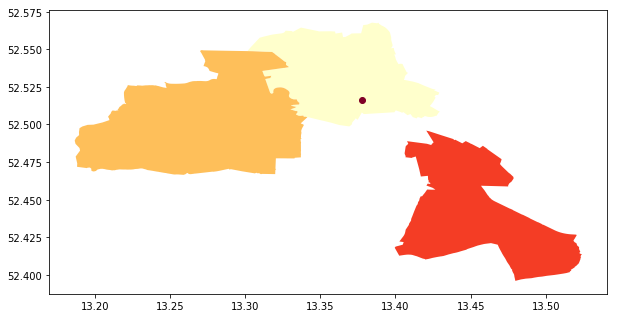

In [15]:
gpd.GeoSeries([mitte, char_wilm, neukoelln, brandenburg_gate]).plot(cmap='YlOrRd', figsize=(10,8));

- We see that the Brandenburg Gate is located in the Mitte district (in bright yellow). 

- Mitte (in bright yellow) and Charlottenburg (in dark yellow) are neighbors, while Mitte (in bright yellow) and Neukölln (in bright red) are not.

Now let's try methods that translate relationships into code:

In [16]:
# contains-method to check whether Mitte contains the famous landmark
mitte.contains(brandenburg_gate)

True

In [17]:
# contains-method to check whether Neukölln contains the famous landmark
neukoelln.contains(brandenburg_gate)

False

In [18]:
# now the same with the within-method --> the order changes!
brandenburg_gate.within(mitte)

True

In [19]:
# touches-method
mitte.touches(char_wilm)

True

### Spatial Relationships in GeoPandas

We just learned about certain spatial relationships between two individual geometry objects. The GeoDataFrame yet has similar methods to apply to *all* of its geometries.

In the next example, we're checking which restaurants are within the polygon of the Mitte district. To perform this operation, we need to make sure both data is using the same Coordinate Reference System (CRS):

In [20]:
# check crs of restaurants
restaurants_geodf.crs

{'init': 'epsg:4326'}

In [21]:
# check crs of berlin_districts
berlin_districs.crs

{'init': 'epsg:4326'}

In [22]:
# checking which restaurants are within the polygon of Mitte
restaurants_geodf.within(mitte).tail()

3976     True
3977    False
3978    False
3979    False
3980    False
dtype: bool

The result of this operation is a Boolean Series that can directly be used as a mask to filter the original dataframe:

In [23]:
mitte_restaurants = restaurants_geodf[restaurants_geodf.within(mitte)]
mitte_restaurants.shape[0]

477

For our dataset, there are 477 restaurants located in Mitte.

### Spatial Joins

It would be interesting to know for each restaurant in which district it is located in. Unfortunately, the districts' names are in another GeoDataFrame. So we need to combine - or: join - both datasets. Joining on location is called a *spatial join*.

To spatially join two GeoDataFrames, GeoPandas provides the `.sjoin()` method. It takes an argument `op` which is short for operation to specify the type of spatial join:

```python
gpd.sjoin(first_gdf, second_gdf, op=<operation>)
```

- The first_gdf is the GeoDataFrame we want to add information to. 
- The second_gdf is the GeoDataFrame that contains the information we want to add. 

*Note, that you need to make sure both GeoDataFrames use the same CRS before you join them!*

- Finally we specify which spatial operation we want to use. The operation can be one of three types: *intersects*, *contains*, or *within*

We use *within* as we want GeoPandas check whether or not rows in the restaurants dataset (left GeoDataFrame) are within the rows of the districts dataset(right GeoDataFrame). Note how the order of the arguments is important here!

In [25]:
restaurants_geodf.crs

{'init': 'epsg:4326', 'no_defs': True}

In [26]:
berlin_districs.crs

{'init': 'epsg:4326'}

In [27]:
joined = gpd.sjoin(restaurants_geodf, berlin_districs, op='within')
joined.head(3)

/anaconda3/envs/geo-env/lib/python3.7/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


,id,lat,lng,name,subCategory,geometry,index_right,OBJECTID,DISTRICT,Shape__Are,Shape__Len,POPULATION,center
0,91911,52.517114,13.461760,Casablanca,Falafel Restaurant,POINT (13.46175956167 52.51711388739101),10,11,Friedrichshain-Kreuzberg,5.496101e+07,53758.825032,285963,POINT (13.42824262906674 52.50381512110913)
2,91947,52.511193,13.449347,Upstalsboom Hotel,Hotel,POINT (13.449347019196 52.511193329824),10,11,Friedrichshain-Kreuzberg,5.496101e+07,53758.825032,285963,POINT (13.42824262906674 52.50381512110913)
5,92007,52.504890,13.385203,relexa hotel Stuttgarter Hof,Hotel,POINT (13.385203007038 52.504889734436),10,11,Friedrichshain-Kreuzberg,5.496101e+07,53758.825032,285963,POINT (13.42824262906674 52.50381512110913)


And here we've chained several functions to group, count, and sort the joined dataframe to see how many restaurants are within each district:

In [28]:
# first subset joined df     
                            ## groupby district  ## count restaurants per district ## sort descending
joined[['name', 'DISTRICT']].groupby('DISTRICT').agg('count').sort_values('name', ascending=False)

,name
DISTRICT,
Mitte,477
Charlottenburg-Wilmersdorf,466
Pankow,424
Steglitz-Zehlendorf,388
Tempelhof-Schöneberg,372
Treptow-Köpenick,318
Neukölln,312
Reinickendorf,284
Friedrichshain-Kreuzberg,265


### Advanced Visualization

In [32]:
import folium

In [33]:
# slice the centroid of Berlin and save the variable as point
point = berlin_districs.center[9]

# reverse the order for folium location array
folium_location = [point.y, point.x]

# construct a folium map for Berlin
berlin_mitte_map = folium.Map(location=folium_location, zoom_start=12)

In [34]:
# slice all restaurants in Mitte
rest_in_mitte = joined[joined['DISTRICT'] == 'Mitte']
rest_in_mitte.shape

(477, 13)

In [37]:
rest_in_mitte.head(2)

,id,lat,lng,name,subCategory,geometry,index_right,OBJECTID,DISTRICT,Shape__Are,Shape__Len,POPULATION,center
7,92022,52.527243,13.396631,Strandbad-Mitte,Breakfast Spot,POINT (13.396631 52.52724300000001),9,10,Mitte,1.062882e+08,58707.772351,379610,POINT (13.36590121143018 52.53287523413531)
9,92034,52.546728,13.349605,L' Escargot,French Restaurant,POINT (13.349604916224 52.546727569166),9,10,Mitte,1.062882e+08,58707.772351,379610,POINT (13.36590121143018 52.53287523413531)


In [44]:
# create a marker for each restaurant
for row in rest_in_mitte.iterrows():
    row_values = row[1] 
    location = [row_values['lat'], row_values['lng']]
    popup = popup = '<strong>' + row_values['name'] + '</strong>'
    marker = folium.Marker(location=location, popup=popup)
    marker.add_to(berlin_mitte_map)

display(berlin_mitte_map)

***Wanna more?***

- Read the [GeoPandas Docs on Spatial Joins](http://geopandas.org/mergingdata.html)
- Read the [Folium Documentation](https://python-visualization.github.io/folium/)